<a href="https://colab.research.google.com/github/lekhuong0196/ML-Predict-Churned-Users/blob/main/ML_Churn-Analysis_sourcecode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_excel('churn_prediction.xlsx')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler

In [ ]:
df.head(1)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93


### **1. Data Preprocessing:**

In [ ]:
# Change all column names to lowercase for easy to mention:
df.columns = df.columns.str.lower()

In [ ]:
# Check imbalance data:
imb_df = df.groupby('churn')['customerid'].count().reset_index()
imb_df['%'] = imb_df['customerid']/sum(imb_df['customerid'])
imb_df

,churn,customerid,%
0,0,4682,0.831616
1,1,948,0.168384





[&rarr; Data is not much imbalanced &rarr; Acceptable]

#### **1.1 Missing values:**

<AxesSubplot:>

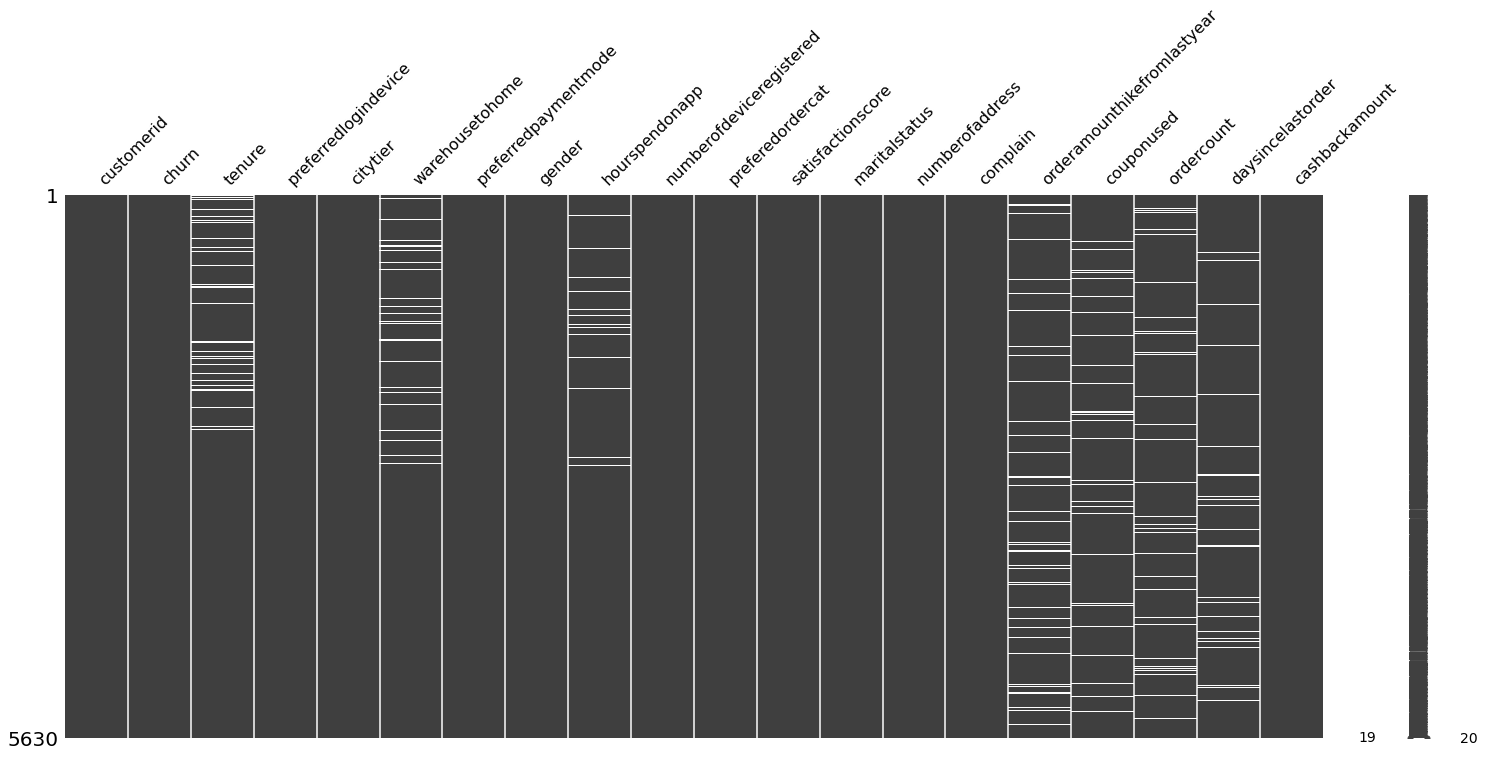

In [ ]:
import missingno as msno
msno.matrix(df)

1. We have 7 columns that have missing values. The amount of missing values is large --> Do not remove --> Replace with other value
2. We need to check these columns are numeric or category.
    - If numeric: replace with mean, median, or 0. If category, replace with mode.
        - Mean: mình sẽ dùng khi cột đó ko có outlier, ko bị skew
        - Median: mình sẽ dùng khi cột có outlier, bị skew  
        - 0: khi cột giá trị của mình có thể tồn tại giá trị 0. Ví dụ: cột đó là cột cân nặng của user, thì ko thể nào có giá trị 0 được
        
&rarr; Mình suggest là chỉ nên thay thế missing value cho numeric columns bằng median hoặc 0 nhen.


In [ ]:
# Check dtypes of columns has missing values:
list_null = df.columns[df.isnull().any()].tolist()
df[list_null].dtypes

tenure                         float64
warehousetohome                float64
hourspendonapp                 float64
orderamounthikefromlastyear    float64
couponused                     float64
ordercount                     float64
daysincelastorder              float64
dtype: object

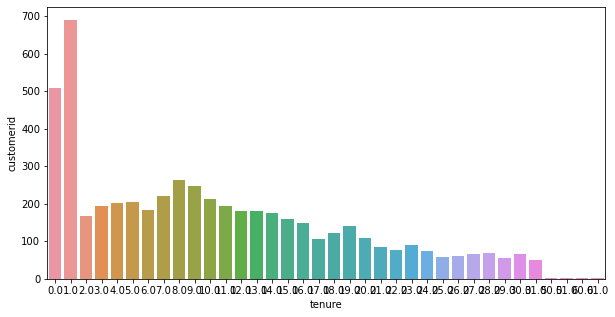

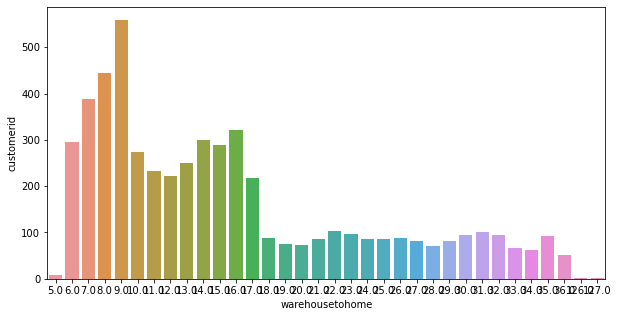

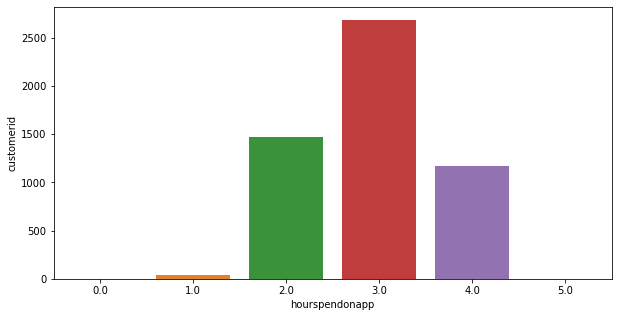

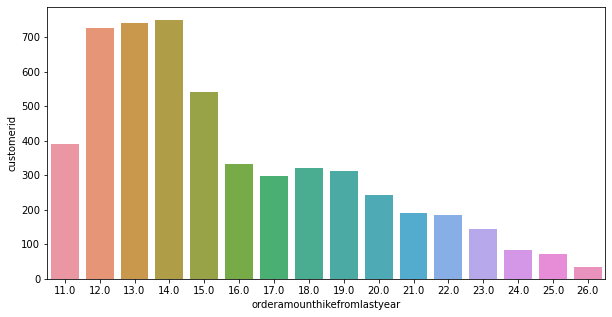

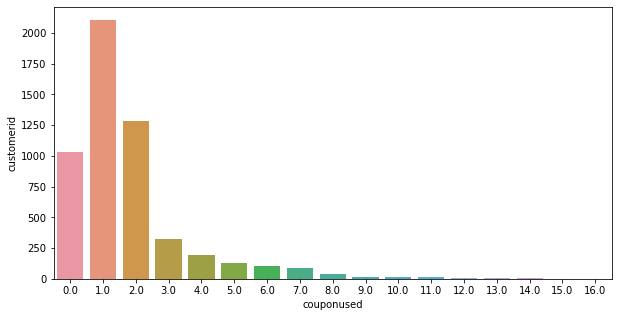

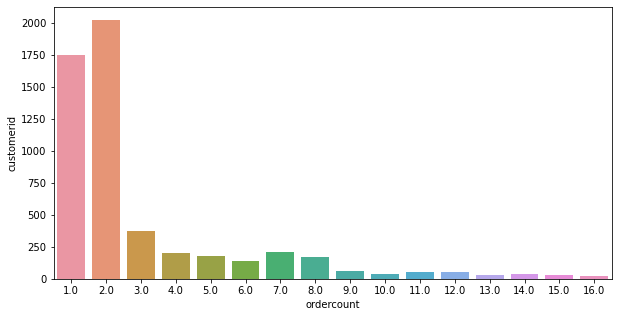

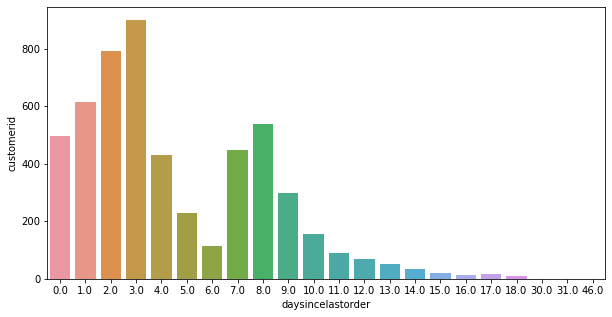

In [ ]:
# Check the distribution to decide we will replace with median or 0:
for i in list_null:
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_df = df.groupby(i)[['customerid']].count().reset_index()
    sns.barplot(data = plot_df,x=plot_df[i],y= plot_df['customerid'],ax=ax)
    plt.show()

After review the distribution, we will replace:
   * The decision was made based on: the meaning of columns and the distribution
        - tenure: median
        - warehousetohome: median
        - hourspendonapp: 0
        - orderamounthikefromlastyear: median
        - couponused: 0
        - ordercount: median
        - daysincelastorder: median

In [ ]:
def replace_func(list_columns):
    for i in list_columns:
        if i in ['tenure','warehousetohome','orderamounthikefromlastyear','ordercount','daysincelastorder']:
            median = df[i].median()
            df[i].fillna(median, inplace=True)
        else:
            df[i].fillna(0, inplace=True)

In [ ]:
replace_func(list_null)

<AxesSubplot:>

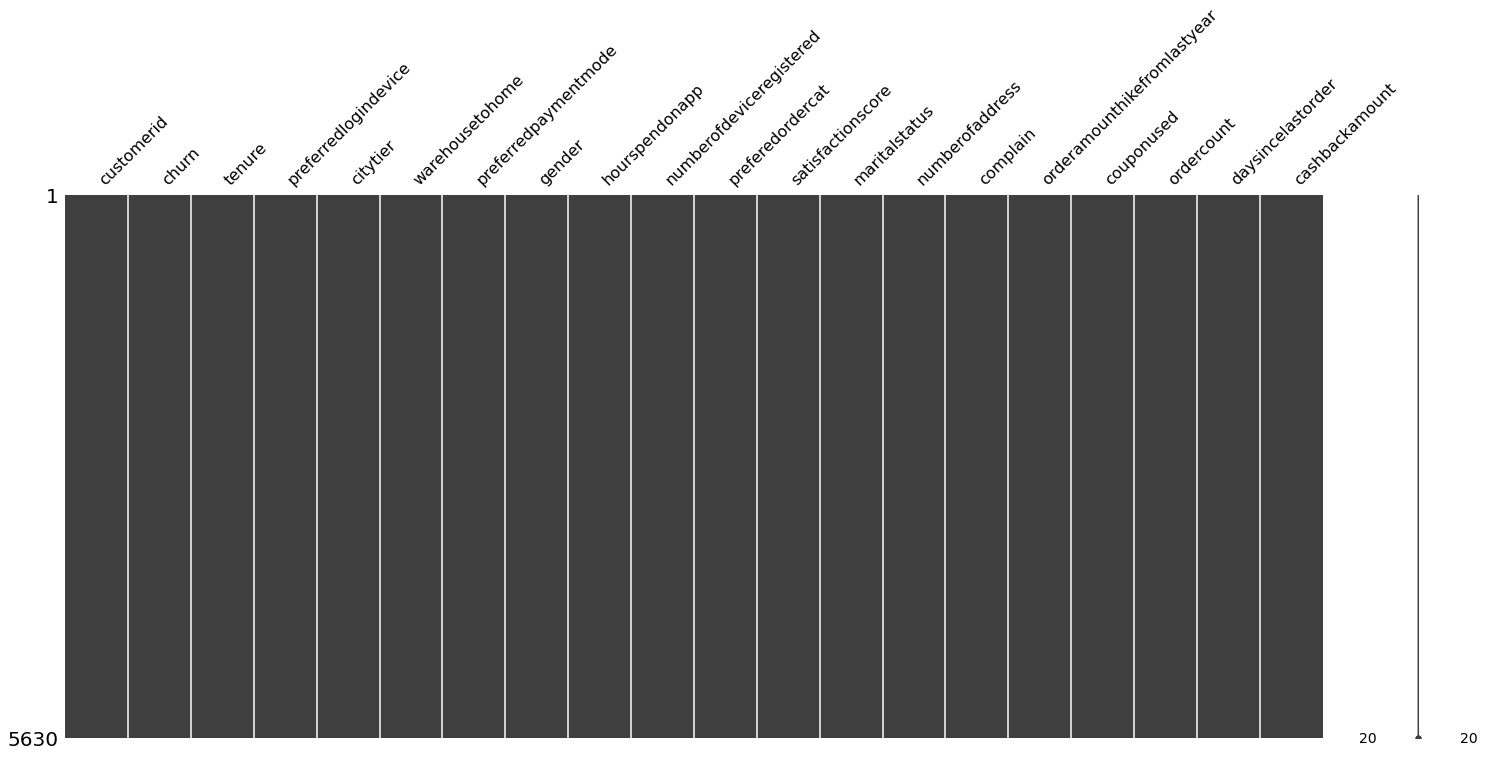

In [ ]:
msno.matrix(df)

#### **1.2 Duplicated Values:**

In [ ]:
df.duplicated().any()

False

&rarr; Data do not have duplicated values

#### **1.3 EDA:**

##### **1.3.1 Check the correlation between all numeric values:**

<AxesSubplot:>

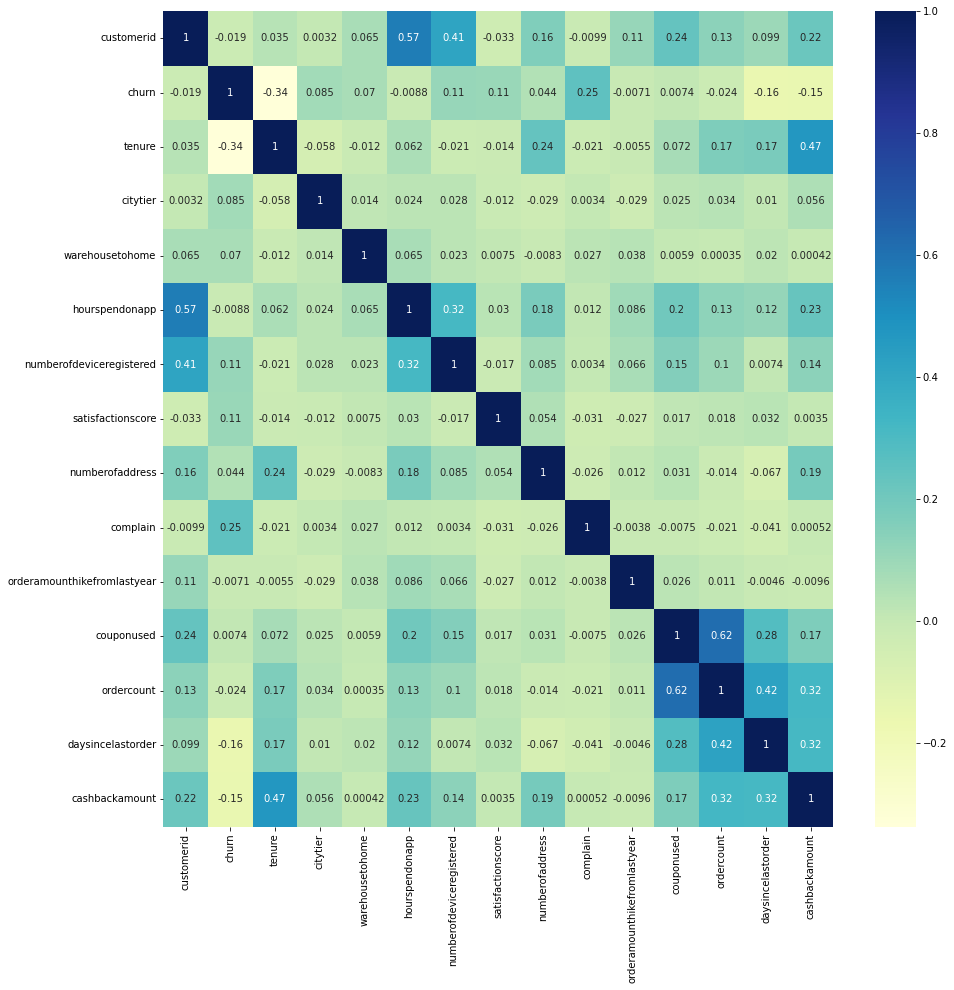

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, ax=ax)

* As noticed, the **couponused** has quite correlation with the **ordercount**. Please note this insight to avoid multilinearity in the futher investigation
* Currently, we found that we do not have any columns that correlation with **churn** columns

&rarr; Continue to EDA steps

##### **1.3.2 Start visualize to decide the columns:**

In [ ]:
df.columns

Index(['customerid', 'churn', 'tenure', 'preferredlogindevice', 'citytier',
       'warehousetohome', 'preferredpaymentmode', 'gender', 'hourspendonapp',
       'numberofdeviceregistered', 'preferedordercat', 'satisfactionscore',
       'maritalstatus', 'numberofaddress', 'complain',
       'orderamounthikefromlastyear', 'couponused', 'ordercount',
       'daysincelastorder', 'cashbackamount'],
      dtype='object')

In [ ]:
# Define a function:
'''
This function to plot the barchart of dataframe
Input:
- the category column need to be groupby
- visualize the data of user churn = 0 or churn=1?

Output:
- the barchart that count "customerid" groupby category column
'''


def cate_visualize(cate_column,churnornot):
    plot_df = df[df['churn']==churnornot].groupby(cate_column)[['customerid']].nunique().reset_index()
    plot_df['%'] = plot_df['customerid']/sum(plot_df['customerid'])
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=plot_df, x=cate_column,y='%', ax=ax)

def numeric_visualize(numeric_column, show_outlier):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=df, x='churn',y=numeric_column,showfliers = show_outlier )



def count_percentage(df, column, target, count):
    '''
    This function to create the table calculate the percentage of fraud/non-fraud transaction on total transaction group by category values

    Input: df: dataframe
    column: the category column need to be groupby
    target: the target column
    count: the column to count the transactions

    Example:
    df = df_train, column = 'job', target = 'is_fraud', count = 'cc_num'

    '''

    # Create 2 dataframes of fraud and non-fraud
    fraud = df[df[target]==1].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)
    not_fraud = df[df[target]==0].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)

    #Merge 2 dataframe into one:
    cate_df = fraud.merge(not_fraud, on = column , how = 'outer')
    cate_df = cate_df.fillna(0)
    cate_df.rename(columns = {count+'_x':'fraud',count+'_y':'not_fraud'}, inplace = True)

    #Caculate the percentage:
    cate_df['%'] = cate_df['fraud']/(cate_df['fraud']+cate_df['not_fraud'])
    cate_df = cate_df.sort_values(by='%', ascending=False)

    return cate_df


##### **Tenure: new users are churned more than old users (tenure = 0 or 1)**

In [ ]:
df['tenure'].unique()

array([ 4.,  9.,  0., 13., 11., 19., 20., 14.,  8., 18.,  5.,  2., 30.,
        1., 23.,  3., 29.,  6., 26., 28.,  7., 24., 25., 10., 15., 22.,
       27., 16., 12., 21., 17., 50., 60., 31., 51., 61.])

<AxesSubplot:xlabel='tenure', ylabel='customerid'>

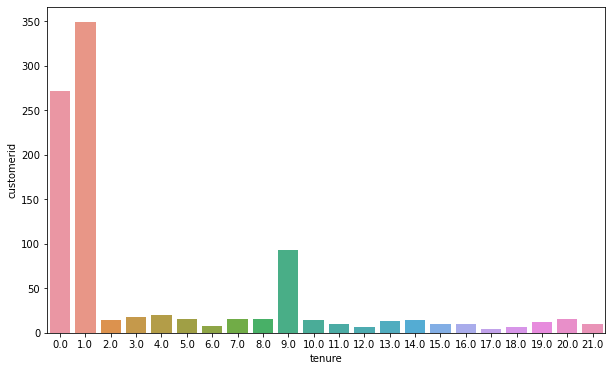

In [ ]:
plot_df = df[df['churn']==1].groupby('tenure')[['customerid']].nunique().reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_df, x='tenure',y='customerid', ax=ax)

<AxesSubplot:xlabel='tenure', ylabel='customerid'>

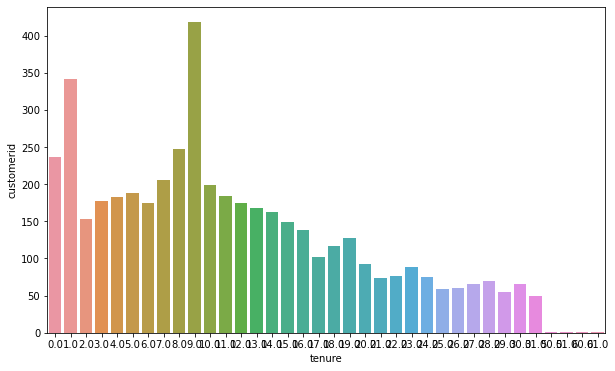

In [ ]:
plot_df = df[df['churn']==0].groupby('tenure')[['customerid']].nunique().reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_df, x='tenure',y='customerid', ax=ax)

In [ ]:
count_percentage(df, 'tenure', 'churn', 'customerid')

,tenure,fraud,not_fraud,%
1,0.0,272.0,236,0.535433
0,1.0,349.0,341,0.505797
2,9.0,93.0,418,0.181996
6,20.0,16.0,93,0.146789
17,21.0,10.0,74,0.119048
3,4.0,20.0,183,0.098522
4,3.0,18.0,177,0.092308
13,19.0,12.0,128,0.085714
9,2.0,14.0,153,0.083832
11,14.0,14.0,162,0.079545


As two plots, we can see that churn users usuallly are new users (tenure mostly is 0 and 1)

##### **Prefer Login Devices**

In [ ]:
df['preferredlogindevice'].unique()

array(['Mobile Phone', 'Phone', 'Computer'], dtype=object)

In [ ]:
#Replace Mobile Phone to Phone
df['preferredlogindevice'].replace({'Mobile Phone':'Phone'}, inplace=True)

In [ ]:
df['preferredlogindevice'].unique()

array(['Phone', 'Computer'], dtype=object)

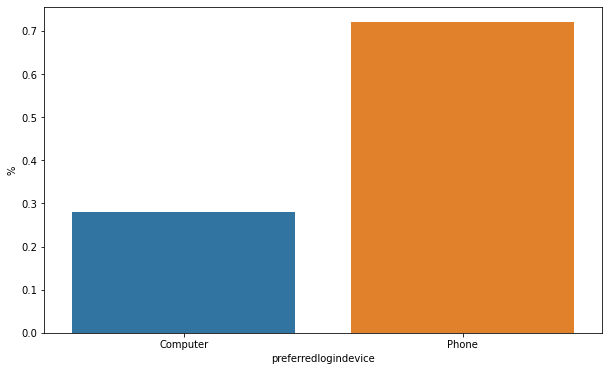

In [ ]:
cate_visualize('preferredlogindevice',0)

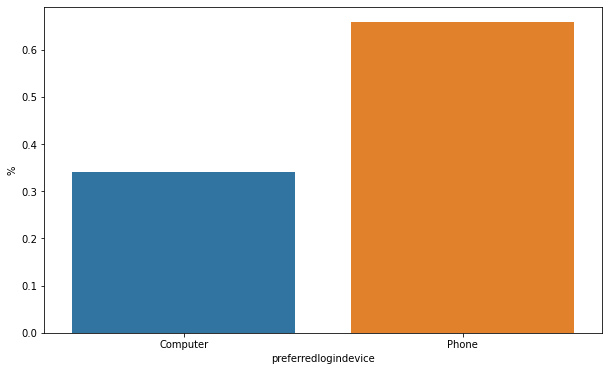

In [ ]:
cate_visualize('preferredlogindevice',1)

In [ ]:
count_percentage(df, 'preferredlogindevice', 'churn', 'customerid')

,preferredlogindevice,fraud,not_fraud,%
1,Computer,324,1310,0.198286
0,Phone,624,3372,0.156156


For both churn or not churn users, they refer to use phone more than computer.

##### **City Tier**

In [ ]:
df['citytier'].unique()

array([3, 1, 2])

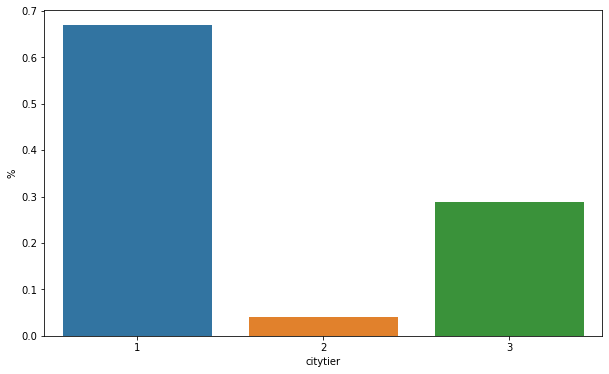

In [ ]:
cate_visualize('citytier',0)

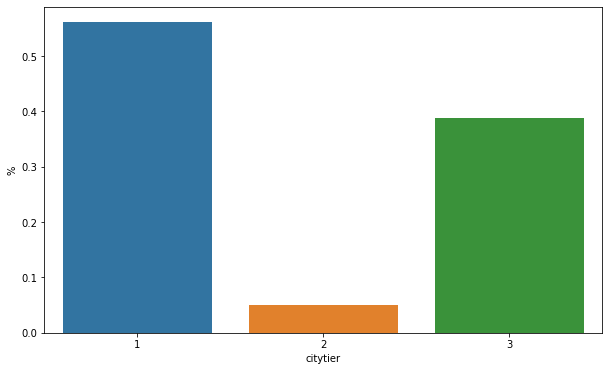

In [ ]:
cate_visualize('citytier',1)

In [ ]:
count_percentage(df, 'citytier', 'churn', 'customerid')

,citytier,fraud,not_fraud,%
1,3,368,1354,0.213705
2,2,48,194,0.198347
0,1,532,3134,0.145117


For both churn or not churn users, they most live in citytier=1 and citytier=3 and in citytier = 3, users tend to churn more.

##### **Warehouse To Home**

In [ ]:
df['warehousetohome'].dtype

dtype('float64')

<AxesSubplot:xlabel='churn', ylabel='warehousetohome'>

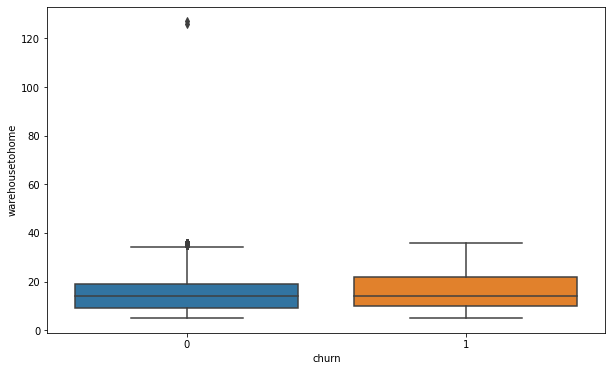

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='churn',y='warehousetohome',ax=ax)

<AxesSubplot:xlabel='churn', ylabel='warehousetohome'>

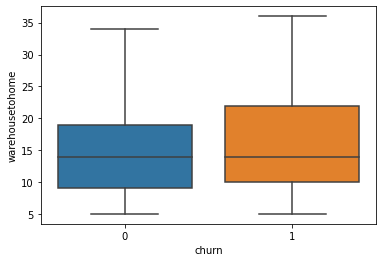

In [ ]:
sns.boxplot(data=df, x='churn',y='warehousetohome', showfliers = False)

We see that the range is not significantly different between churn & not churn users.

##### **Preferred Payment Mode**

In [ ]:
df['preferredpaymentmode'].unique()

array(['Debit Card', 'UPI', 'CC', 'Cash on Delivery', 'E wallet', 'COD',
       'Credit Card'], dtype=object)

In [ ]:
df['preferredpaymentmode'].replace({'CC':'Credit Card','COD':'Cash on Delivery'}, inplace=True)

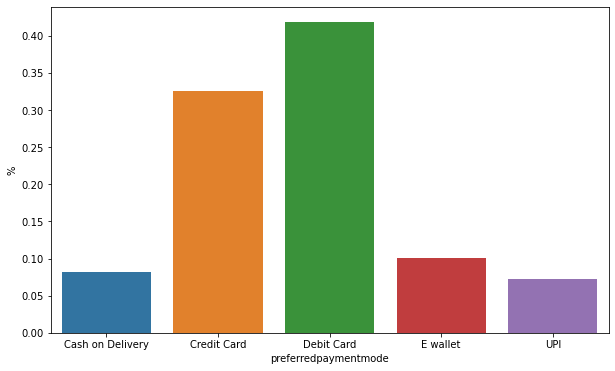

In [ ]:
cate_visualize('preferredpaymentmode',0)

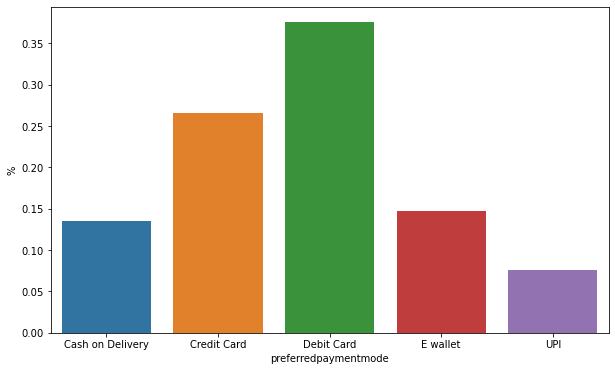

In [ ]:
cate_visualize('preferredpaymentmode',1)

In [ ]:
count_percentage(df, 'preferredpaymentmode', 'churn', 'customerid')

,preferredpaymentmode,fraud,not_fraud,%
3,Cash on Delivery,128,386,0.249027
2,E wallet,140,474,0.228013
4,UPI,72,342,0.173913
0,Debit Card,356,1958,0.153846
1,Credit Card,252,1522,0.142052


There's no significant difference in payment method between churned & not churned users

##### **Gender**

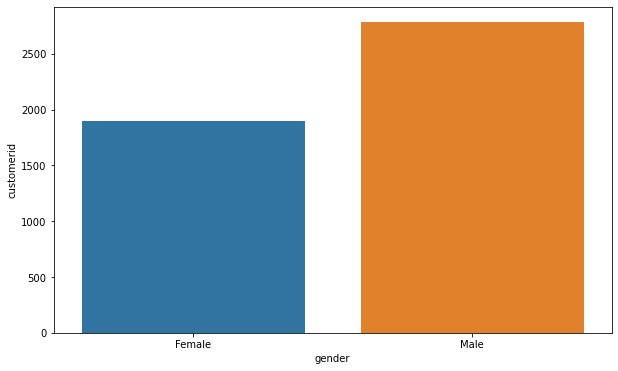

In [ ]:
cate_visualize('gender',0)

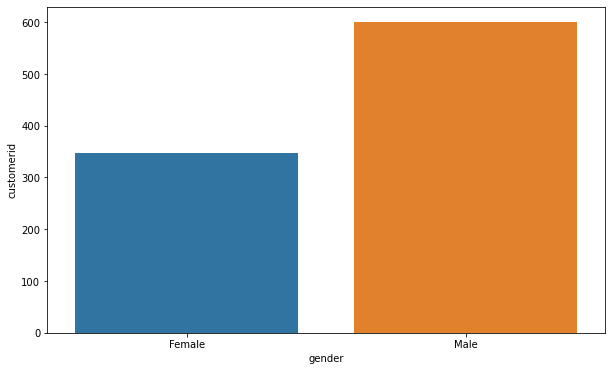

In [ ]:
cate_visualize('gender',1)

In [ ]:
count_percentage(df, 'gender', 'churn', 'customerid')

,gender,fraud,not_fraud,%
0,Male,600,2784,0.177305
1,Female,348,1898,0.154942


There's no significant difference in gender between churned & not churned users

##### **Hour Spend on app**

In [ ]:
df['hourspendonapp'].dtype

dtype('float64')

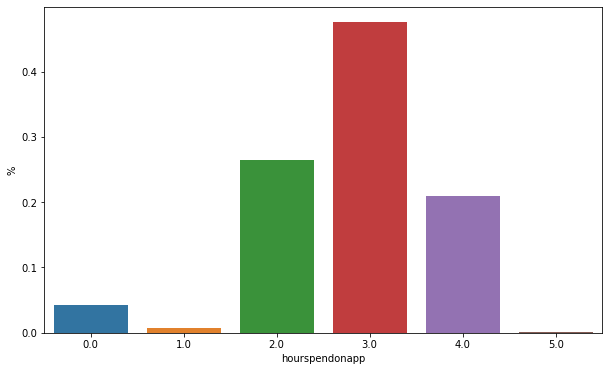

In [ ]:
cate_visualize('hourspendonapp',0)

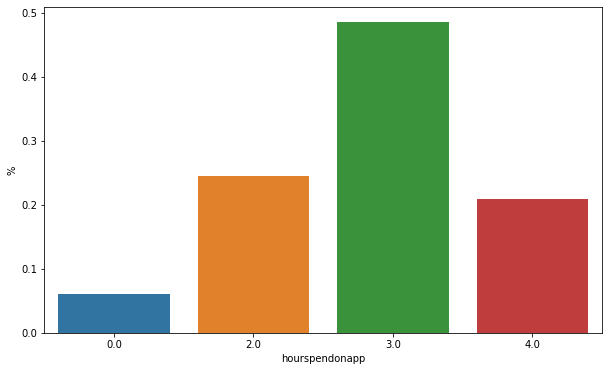

In [ ]:
cate_visualize('hourspendonapp',1)

In [ ]:
count_percentage(df, 'hourspendonapp', 'churn', 'customerid')

,hourspendonapp,fraud,not_fraud,%
3,0.0,58.0,200,0.224806
0,3.0,460.0,2227,0.171195
2,4.0,198.0,978,0.168367
1,2.0,232.0,1239,0.157716
4,1.0,0.0,35,0.000000
5,5.0,0.0,3,0.000000


We saw that in hour =1 and hour =5, there's no fraud users. However, the sample in these range of hour is too small, which not significant for us to conclude.

&rarr; We can conclude there's no significantly different between churn and not churn in hours they spent on app


##### **Number of devices registering: The more devices users registered, the more users tend to fraud**

In [ ]:
df['numberofdeviceregistered'].unique()

array([3, 4, 5, 2, 1, 6])

In [ ]:
df['numberofdeviceregistered'].dtype

dtype('int64')

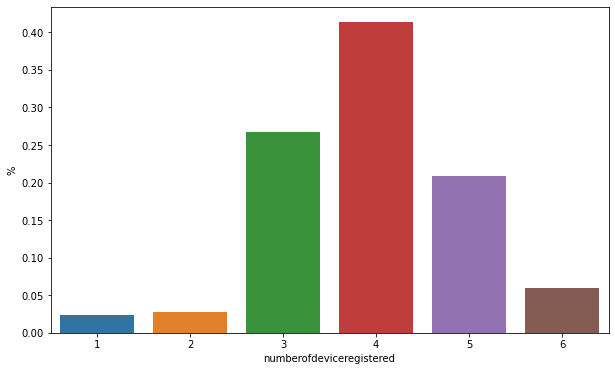

In [ ]:
cate_visualize('numberofdeviceregistered',1)

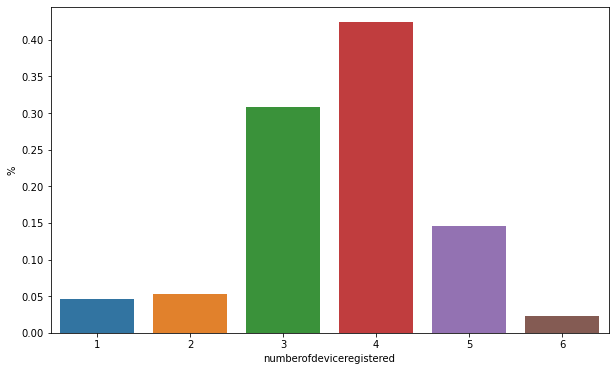

In [ ]:
cate_visualize('numberofdeviceregistered',0)

In [ ]:
count_percentage(df, 'numberofdeviceregistered', 'churn', 'customerid')

,numberofdeviceregistered,fraud,not_fraud,%
3,6,56,106,0.345679
2,5,198,683,0.224745
0,4,392,1985,0.164914
1,3,254,1445,0.149500
4,2,26,250,0.094203
5,1,22,213,0.093617


&rarr; The more devices users registered, the more users tend to fraud.

##### **Prefer orders category: Churn users refer to buy Mobile Phone than others**

In [ ]:
df['preferedordercat'].unique()

array(['Laptop & Accessory', 'Mobile', 'Mobile Phone', 'Others',
       'Fashion', 'Grocery'], dtype=object)

In [ ]:
df['preferedordercat'].replace({'Mobile':'Mobile Phone'},inplace=True)

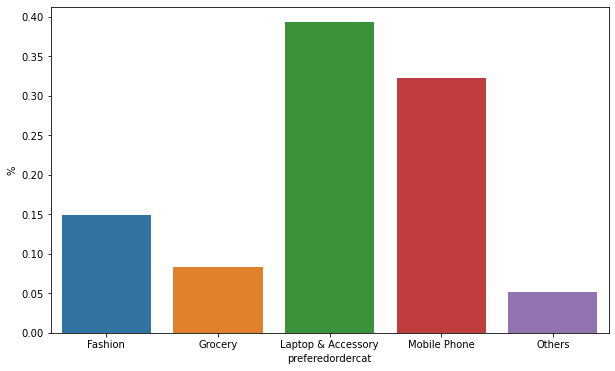

In [ ]:
cate_visualize('preferedordercat',0)

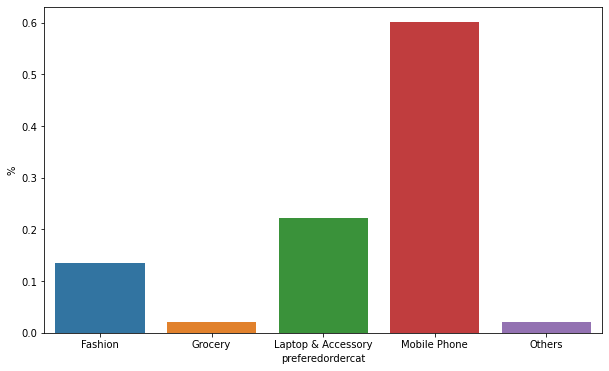

In [ ]:
cate_visualize('preferedordercat',1)

In [ ]:
count_percentage(df, 'preferedordercat', 'churn', 'customerid')

,preferedordercat,fraud,not_fraud,%
0,Mobile Phone,570,1510,0.274038
2,Fashion,128,698,0.154964
1,Laptop & Accessory,210,1840,0.102439
4,Others,20,244,0.075758
3,Grocery,20,390,0.048780


For churned users,
* They refer to buy Mobile Phone than others.
* They buy Grocery and Laptop less than not churn users.


##### **Satisfaction Score**

In [ ]:
df['satisfactionscore'].unique()

array([2, 3, 5, 4, 1])

In [ ]:
df['satisfactionscore'].dtype

dtype('int64')

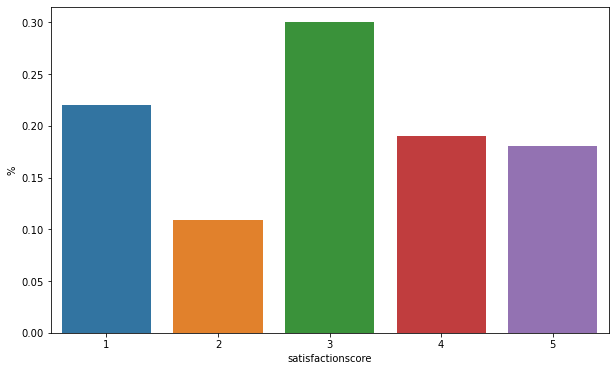

In [ ]:
cate_visualize('satisfactionscore',0)

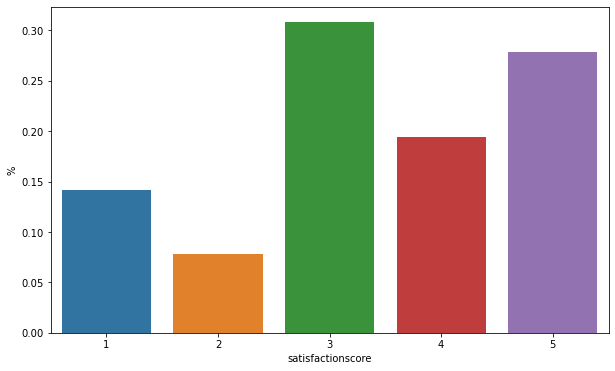

In [ ]:
cate_visualize('satisfactionscore',1)

In [ ]:
count_percentage(df, 'satisfactionscore', 'churn', 'customerid')

,satisfactionscore,fraud,not_fraud,%
1,5,264,844,0.238267
0,3,292,1406,0.171967
2,4,184,890,0.171322
4,2,74,512,0.126280
3,1,134,1030,0.115120


Churn users have lower percentage in score = 1 than not churn users and higher in score = 5

&rarr; Although there're significantly different between churn and not churn in score 1 and 5, there's no making sense as logical aspect. If we add this feature into model, non logic result can happen.

##### **Maritual Status: Churned users have status Single more than notchurn users**

In [ ]:
df['maritalstatus'].unique()

array(['Single', 'Divorced', 'Married'], dtype=object)

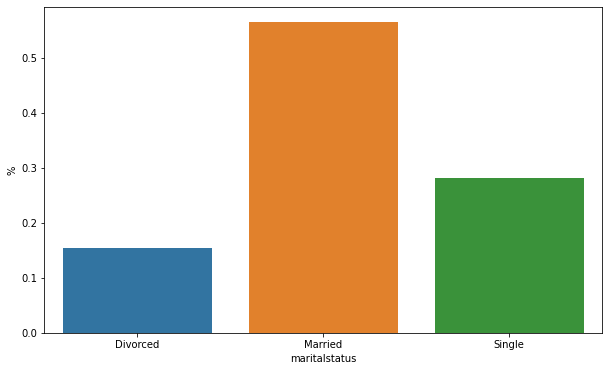

In [ ]:
cate_visualize('maritalstatus',0)

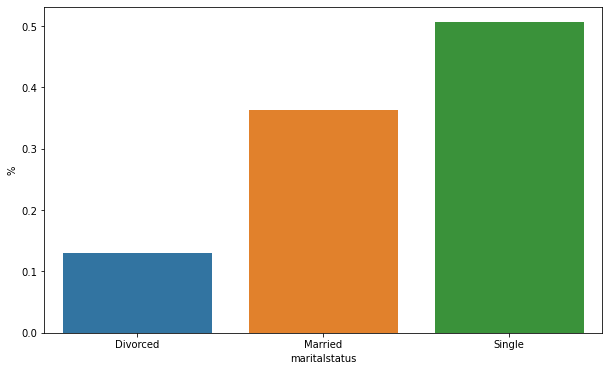

In [ ]:
cate_visualize('maritalstatus',1)

In [ ]:
count_percentage(df, 'maritalstatus', 'churn', 'customerid')

,maritalstatus,fraud,not_fraud,%
0,Single,480,1316,0.267261
2,Divorced,124,724,0.146226
1,Married,344,2642,0.115204


Churned users have status Single more than notchurn users. And notchurn users have married status more than churn.

&rarr; We can add this feature to the model

##### **Number of Address**

In [ ]:
df['numberofaddress'].dtype

dtype('int64')

In [ ]:
df['numberofaddress'].unique()

array([ 9,  7,  6,  8,  3,  2,  4, 10,  1,  5, 19, 21, 11, 20, 22])

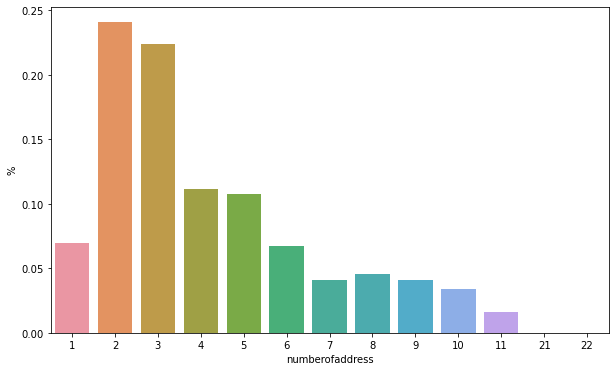

In [ ]:
cate_visualize('numberofaddress',0)

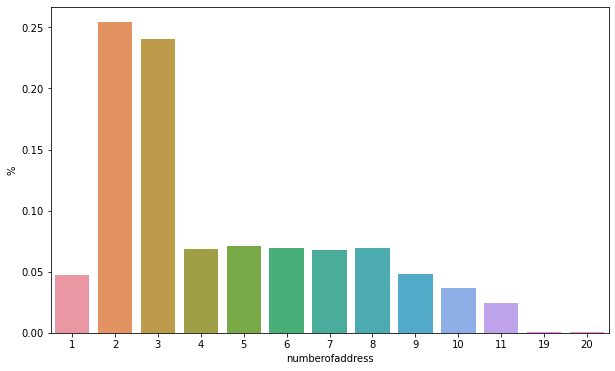

In [ ]:
cate_visualize('numberofaddress',1)

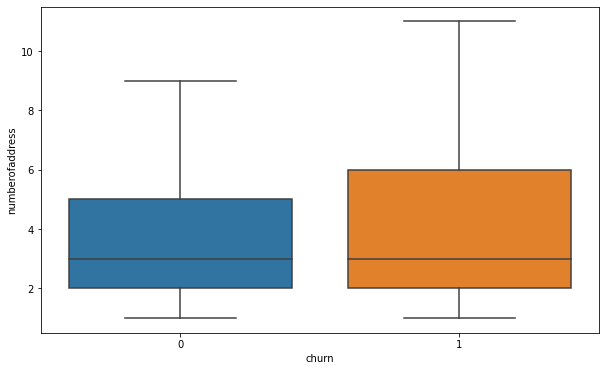

In [ ]:
numeric_visualize('numberofaddress', False)

In [ ]:
count_percentage(df, 'numberofaddress', 'churn', 'customerid')

,numberofaddress,fraud,not_fraud,%
11,19,1.0,0.0,1.000000
12,20,1.0,0.0,1.000000
6,7,64.0,192.0,0.250000
4,8,66.0,214.0,0.235714
10,11,23.0,75.0,0.234694
7,9,46.0,193.0,0.192469
9,10,35.0,159.0,0.180412
1,3,228.0,1050.0,0.178404
0,2,241.0,1128.0,0.176041
3,6,66.0,316.0,0.172775


There're no significant difference between churn and not churn users in number of address

##### **Complain: The number of users complain on churn is higher than not churn**

In [ ]:
df['complain'].dtype

dtype('int64')

In [ ]:
df['complain'].unique()

array([1, 0])

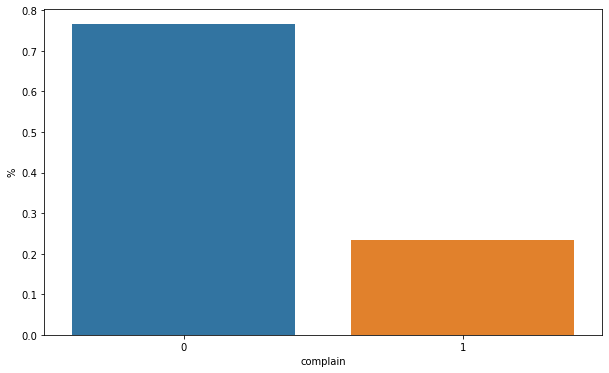

In [ ]:
cate_visualize('complain',0)

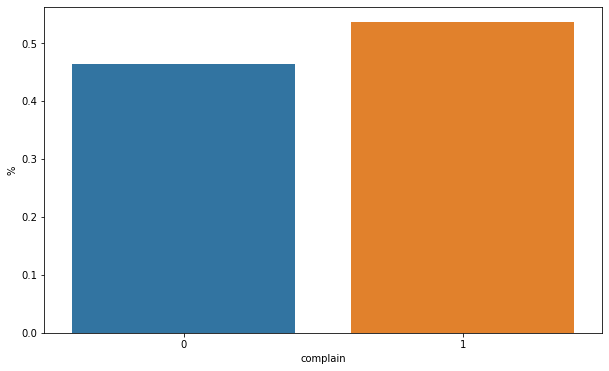

In [ ]:
cate_visualize('complain',1)

In [ ]:
count_percentage(df, 'complain', 'churn', 'customerid')

,complain,fraud,not_fraud,%
0,1,508,1096,0.316708
1,0,440,3586,0.109290


The number of users complain on churn is higher than not churn

&rarr; Use this feature on the model

##### **Order Hike from Last year**

In [ ]:
df['orderamounthikefromlastyear'].dtype

dtype('float64')

In [ ]:
df['orderamounthikefromlastyear'].unique()

array([11., 15., 14., 23., 22., 16., 12., 13., 17., 18., 24., 19., 20.,
       21., 25., 26.])

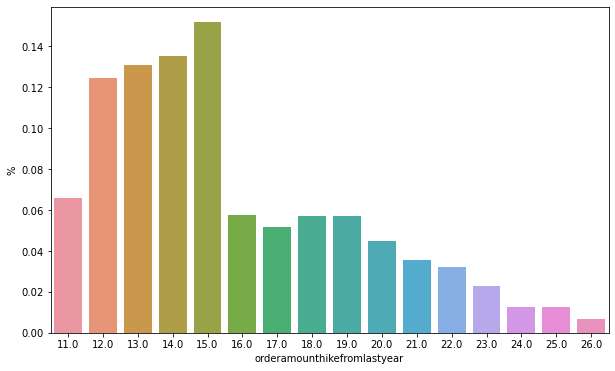

In [ ]:
cate_visualize('orderamounthikefromlastyear',0)

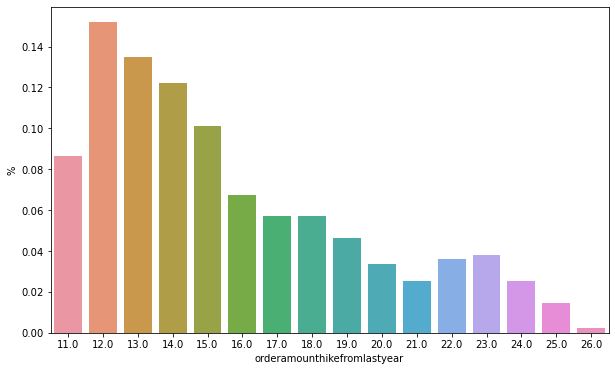

In [ ]:
cate_visualize('orderamounthikefromlastyear',1)

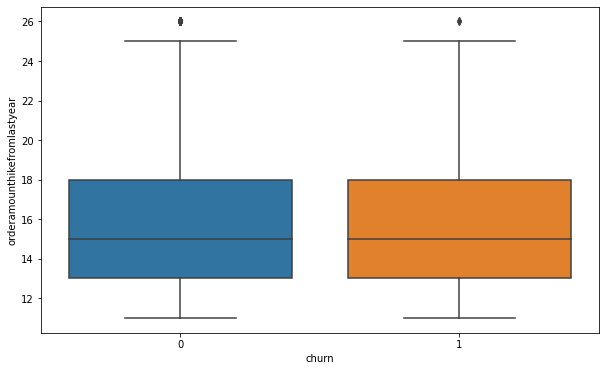

In [ ]:
numeric_visualize('orderamounthikefromlastyear', True)

In [ ]:
count_percentage(df, 'orderamounthikefromlastyear', 'churn', 'customerid')

,orderamounthikefromlastyear,fraud,not_fraud,%
13,24.0,24,60,0.285714
9,23.0,36,108,0.250000
4,11.0,82,309,0.209719
0,12.0,144,584,0.197802
5,16.0,64,269,0.192192
14,25.0,14,59,0.191781
10,22.0,34,150,0.184783
6,17.0,54,243,0.181818
1,13.0,128,613,0.172740
7,18.0,54,267,0.168224


There're no significant difference between churn and not churn users in order hike from last year.

##### **Coupon Used**

In [ ]:
df['couponused'].unique()

array([ 1.,  0.,  4.,  2.,  9.,  6., 11.,  7., 12., 10.,  5.,  3., 13.,
       15.,  8., 14., 16.])

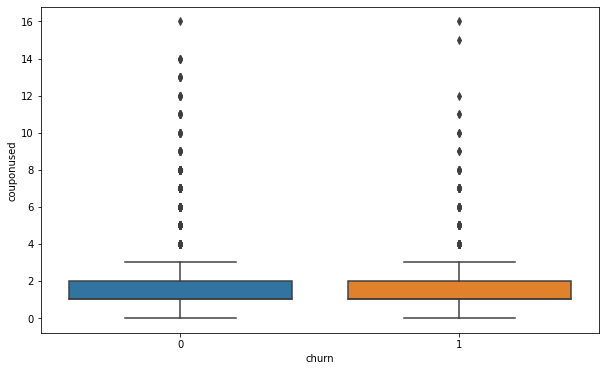

In [ ]:
numeric_visualize('couponused',True)

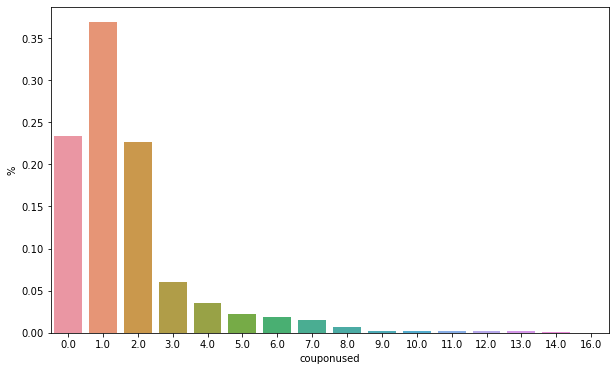

In [ ]:
cate_visualize('couponused',0)

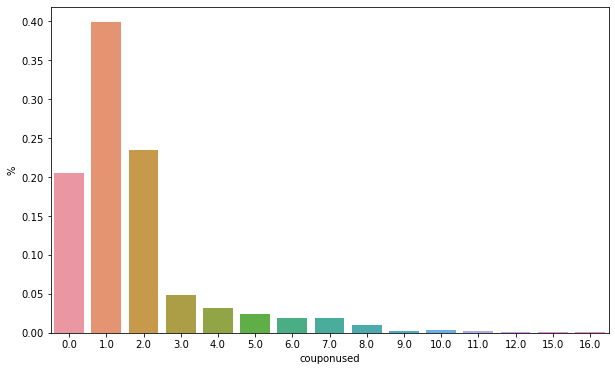

In [ ]:
cate_visualize('couponused',1)

There're no significant difference between churn and not churn users in order hike from last year.

##### **Order Count**

In [ ]:
df['ordercount'].unique()

array([ 1.,  6.,  2., 15.,  4.,  7.,  3.,  9., 11.,  5., 12., 10.,  8.,
       13., 14., 16.])

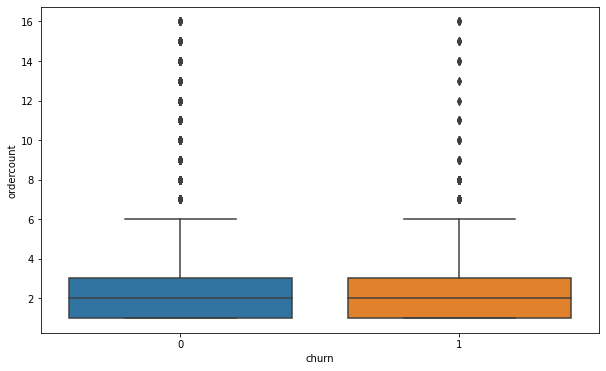

In [ ]:
numeric_visualize('ordercount',True)

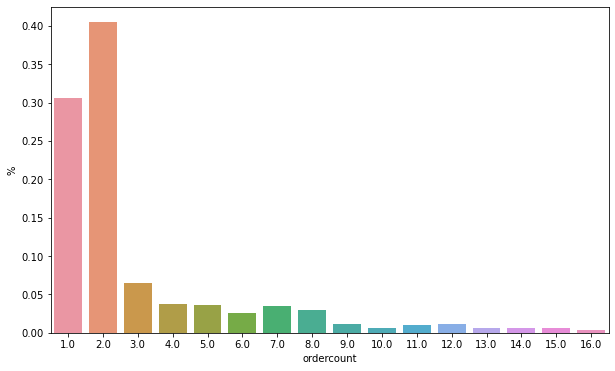

In [ ]:
cate_visualize('ordercount',0)

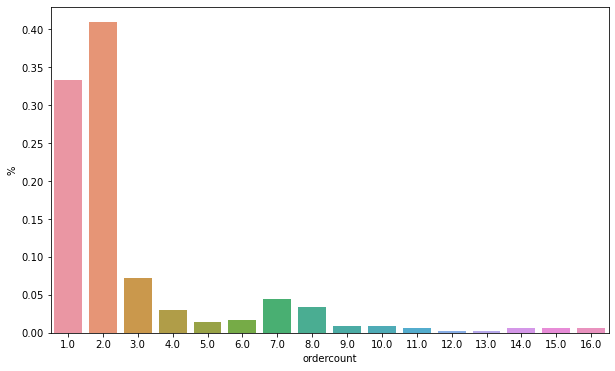

In [ ]:
cate_visualize('ordercount',1)

In [ ]:
count_percentage(df, 'ordercount', 'churn', 'customerid')

,ordercount,fraud,not_fraud,%
13,16.0,6,17,0.260870
9,10.0,8,28,0.222222
3,7.0,42,164,0.203883
4,8.0,32,140,0.186047
2,3.0,68,303,0.183288
12,15.0,6,27,0.181818
1,1.0,316,1435,0.180468
0,2.0,388,1895,0.169952
11,14.0,6,30,0.166667
5,4.0,28,176,0.137255


There're no significant difference between churn and not churn users in order count.

##### **Day Since Last Order**

In [ ]:
df['daysincelastorder'].unique()

array([ 5.,  0.,  3.,  7.,  2.,  1.,  8.,  6.,  4., 15.,  9., 11., 10.,
       13., 12., 17., 16., 14., 30., 46., 18., 31.])

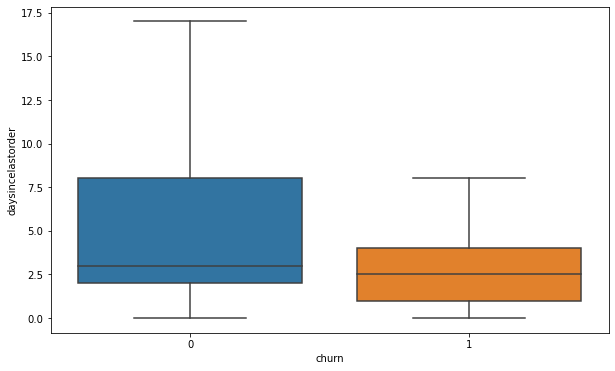

In [ ]:
numeric_visualize('daysincelastorder',False)

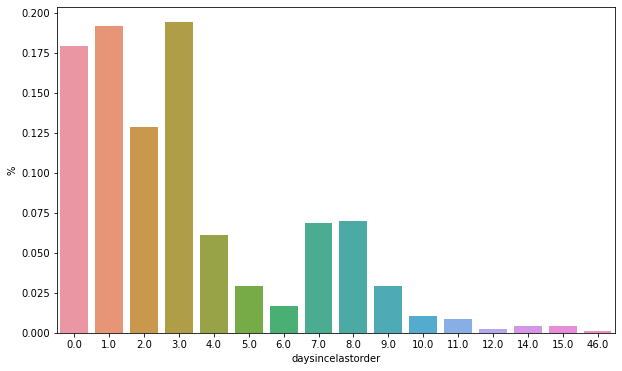

In [ ]:
cate_visualize('daysincelastorder',1)

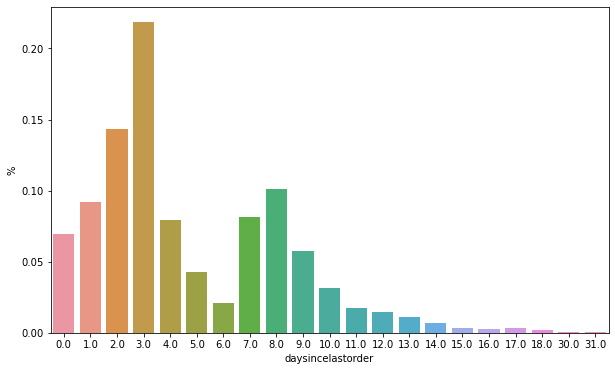

In [ ]:
cate_visualize('daysincelastorder',0)

There're no significant difference between churn and not churn users in days from last orders.

##### **Cashback Amount: Churn users recevied cashback amount less than not churn users.**

In [ ]:
df['cashbackamount'].nunique()

2586

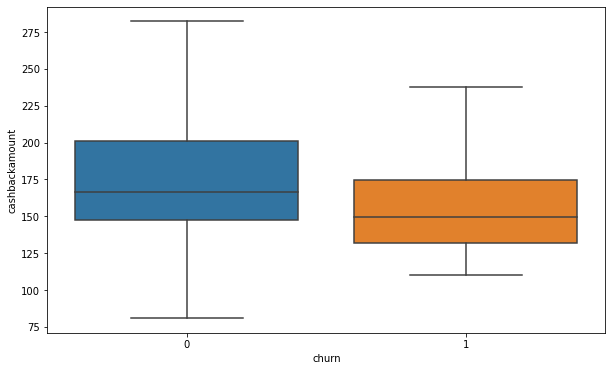

In [ ]:
numeric_visualize('cashbackamount',False)

Churn users recevied cashback amount less than not churn users.

&rarr; Use this feature for model

##### **1.3.3 Conclusion after EDA:**

**After review all features, we can have the insight that:**
* Churn users usually the new users
* They refer to buy Mobile Phone
* They usually are in single status
* They have the complains
* They received less cashback amount than others

&rarr; **We can have some suggestions based on these insights:**
* We can have more promotions or special discounts for new users
* We can have more recommended products in other category when Mobile Phone order completed.
* With users that have complains for us, we can reach out to them, offer them vouchers or any special offers.

### **2. Data Transforming:**

In this case, we will uses the model Decision Tree and other model based on the algorithm of decision tree

&rarr; Firstly, I will use all features for the model to review the accuracy.

#### **2.1 Encoding**

In [ ]:
cate_columns = df.loc[:, df.dtypes == np.object].columns.tolist()
cate_columns

['preferredlogindevice',
 'preferredpaymentmode',
 'gender',
 'preferedordercat',
 'maritalstatus']

In [ ]:
encoded_df = pd.get_dummies(df, columns = cate_columns,drop_first=True)
encoded_df.shape

(5630, 27)

#### **2.2 Normalizing**

In [ ]:
#Scale Feature:
scaler = MinMaxScaler()
model=scaler.fit(encoded_df)
scaled_data=model.transform(encoded_df)

In [ ]:
scaled_df = pd.DataFrame(scaled_data, columns = encoded_df.columns.tolist())
scaled_df.drop(columns = 'customerid',inplace=True)

In [ ]:
scaled_df

,churn,tenure,citytier,warehousetohome,hourspendonapp,numberofdeviceregistered,satisfactionscore,numberofaddress,complain,orderamounthikefromlastyear,...,preferredpaymentmode_Debit Card,preferredpaymentmode_E wallet,preferredpaymentmode_UPI,gender_Male,preferedordercat_Grocery,preferedordercat_Laptop & Accessory,preferedordercat_Mobile Phone,preferedordercat_Others,maritalstatus_Married,maritalstatus_Single
0,1.0,0.065574,1.0,0.008197,0.6,0.4,0.25,0.380952,1.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.147541,0.0,0.024590,0.6,0.6,0.50,0.285714,1.0,0.266667,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.147541,0.0,0.204918,0.4,0.6,0.50,0.238095,1.0,0.200000,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.000000,1.0,0.081967,0.4,0.6,1.00,0.333333,0.0,0.800000,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.000000,0.0,0.057377,0.0,0.4,1.00,0.095238,0.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,0.0,0.163934,0.0,0.204918,0.6,0.2,0.00,0.238095,0.0,0.466667,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5626,0.0,0.213115,0.0,0.065574,0.6,0.8,1.00,0.238095,0.0,0.333333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5627,0.0,0.016393,0.0,0.049180,0.6,0.2,0.75,0.095238,1.0,0.666667,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5628,0.0,0.377049,1.0,0.032787,0.8,0.8,0.75,0.142857,0.0,0.266667,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


### **3. Model Training & Evaluation**

#### **3.1 Split train/test set:**

In [ ]:
from sklearn.model_selection import train_test_split
x=scaled_df.drop('churn', axis = 1)
y=scaled_df[['churn']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

#### **3.2 Apply model: Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_logis = LogisticRegression(random_state = 0)
clf_logis.fit(x_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
y_pred_test = clf_logis.predict(x_test)
y_pred_train = clf_logis.predict(x_train)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_train = balanced_accuracy_score(y_train, y_pred_train)
balanced_accuracy_test = balanced_accuracy_score(y_test, y_pred_test)
print(balanced_accuracy_train,balanced_accuracy_test)

0.717935635343012 0.7131334832838748


&rarr; The balanced accuracy of Logistic Regression is 71%
No unerfitting or overfitting

However, we use Logistic Regression only for linear features base. In this case, we are trying all features into the model, so the Logistic Regression can not reflect the data correctly.

#### **3.2 Apply model: Decision Tree**

In [ ]:
from sklearn import tree

clf_des = tree.DecisionTreeClassifier()
clf_des.fit(x_train,y_train)

DecisionTreeClassifier()

In [ ]:
y_tree_pre_train = clf_des.predict(x_train)
y_tree_pre_test = clf_des.predict(x_test)

In [ ]:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_tree_pre_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_tree_pre_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.907384539133101


&rarr; The balanced accuracy of Decision Tree is 89%.
Seems quite overfitting

Because the Decision Tree model is easily overfitting, we will try random forest instead.

#### **3.3 Apply model: Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rand = RandomForestClassifier(max_depth=2, random_state=0)

clf_rand.fit(x_train, y_train)
y_ranf_pre_train = clf_rand.predict(x_train)
y_ranf_pre_test = clf_rand.predict(x_test)

In [ ]:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_tree_pre_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_tree_pre_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.907384539133101


&rarr; The balanced accuracy of Random Forest is 90%.
Seems quite overfitting

#### **3.4 Enhanced Random Forest model**



```
`# This is formatted as code`
```

**Show the Feature Importances:**

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_test.columns, clf_rand.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=True)

importances = importances.reset_index()

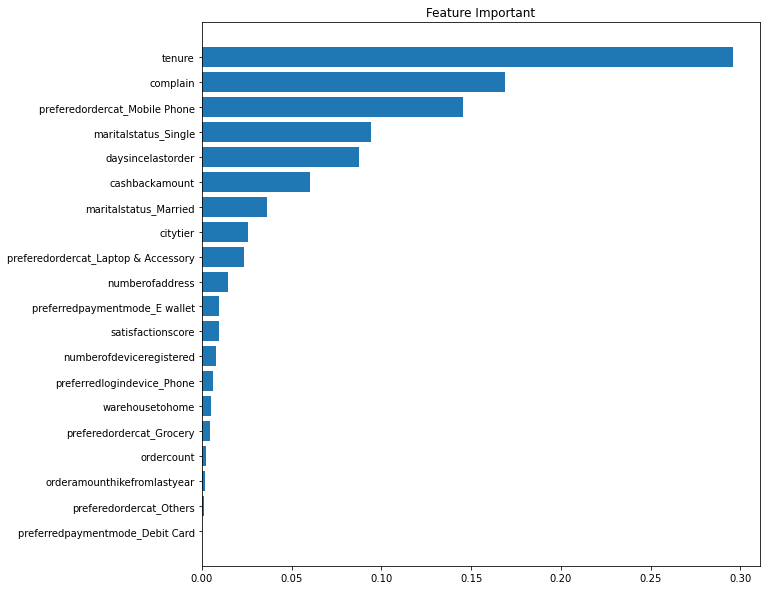

In [ ]:
# Create bar chart
plt.figure(figsize=(10, 10))
plt.barh(importances.tail(20)['index'][:20], importances.tail(20)['Gini-importance'])

plt.title('Feature Important')

# Show plot
plt.show()

The model takes Tenure and Complain as the two highest important features

&rarr; Make sense with the features that we EDA in below

**Hyperparameter Tuning**

We will go through all hyperparameters of Random Forest model to define with hyperparameters will bring the best balanced_accuracy for the data

In [ ]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(clf_rand, param_grid, cv=5, scoring='balanced_accuracy')

# Fit the model
grid_search.fit(x_train, y_train)
/
# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Evaluate the best model on the test set
best_clf = grid_search.best_estimator_
accuracy = best_clf.score(x_test, y_test)
print("Test set accuracy: ", accuracy)

Best Parameters:  {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Test set accuracy:  0.965016146393972


In [ ]:
#Apply best hyperparameter model to the data:

from sklearn import tree

clf_rand_tun = RandomForestClassifier(
    n_estimators= 100,
    max_depth= 20,
    min_samples_split= 2,
    min_samples_leaf= 1,
    bootstrap= False)

clf_rand_tun.fit(x_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=20)

In [ ]:
y_rand_tun_train = clf_rand_tun.predict(x_train)
y_rand_tun_test = clf_rand_tun.predict(x_test)

In [ ]:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_rand_tun_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_rand_tun_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.9199234706199846


In [ ]:
y_rand_tun_proba = clf_rand_tun.predict_proba(x_test)[:,1]
y_rand_tun_proba

array([1.  , 0.01, 0.  , ..., 0.02, 0.11, 1.  ])

**Probability Threshold selection**

As default, model will get probability threshold = 0.5 for the model. If we change the probability threshold, the accuracy of model can improve? We will use ROC curve to check which probability threshold will have highest True Positive Rate and loweest False Positive rate

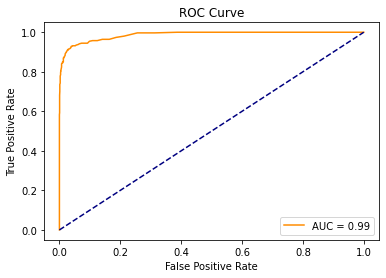

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


fpr, tpr, thresholds = roc_curve(y_test, y_rand_tun_proba)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Calculate the distance for each threshold
distances = np.sqrt((0 - fpr)**2 + (1 - tpr)**2)
# Get the threshold for the smallest distance
best_threshold = thresholds[np.argmin(distances)]
print(f"Best threshold: {best_threshold}")

Best threshold: 0.23


In [ ]:
threshold = 0.23

y_pred_prod = (y_rand_tun_proba > threshold).astype(int)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred_prod)
print("Test balanced accurary :", round(balanced_accuracy,5))

Test balanced accurary : 0.94354


After hyperparameter tuning & probability threshold selecition, we will choose the model Random Forest with the hyperparameter as below and the probability = 0.23.
* n_estimators= 100,
* max_depth= 20,
* min_samples_split= 2,
* min_samples_leaf= 1,
* bootstrap= False
